# Projet de Phase 2 : Analyse de Données Cinématographiques

Travail réaliser par **LUBEQUA Shelton** |Le 11 Octobre 2025

**Objectif :** Analyser le marché du cinéma contemporain pour fournir des recommandations stratégiques basées sur les données 

### Compréhension des Affaires
**Problème Commercial :** Un nouveau studio de cinéma souhaite entrer sur le marché mais manque d'expertise en production cinématographique.
Il a besoin de comprendre quels types de films produire pour maximiser ses chances de succès commercial.

**Public :** Directeur du nouveau studio de cinéma

### Questions Commerciales Clés :
1. Quels genres cinématographiques sont les plus rentables et stables ?
2. Quelle stratégie budgétaire optimise le retour sur investissement ?
3. Quels sont les moments optimaux pour sortir un film ?
4. Comment la durée d'un film influence-t-elle son succès ?
5. Quel est l'impact des notes du public sur la performance commerciale ?

**Outils :** Python, Pandas, Matplotlib, Power BI
 
**Jeu de donneees :** - bom.movie_gross.csv.gz
                          -tn.movie_budgets.csv.gz
                          -im.db

# Importation des donnees


In [9]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import warnings

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Bibliothèques importées et configurées avec succès")

✅ Bibliothèques importées et configurées avec succès


# Connexion a la base de donnees
 on a cree une base de donnees,movie_analysis.db qui fusionne les autres donnees car im

In [35]:
# Connexion à la base de données SQLite
print("📊 ÉTAPE 1: CONNEXION À LA BASE DE DONNÉES")

try:
    # Connexion à la base SQLite (création si n'existe pas)
    conn = sqlite3.connect('movie_analysis.db')
    cursor = conn.cursor()
    print("✅ Connexion à 'movie_analysis.db' réussie")
    
    # Vérifier les tables existantes
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    existing_tables = cursor.fetchall()
    table_names = [table[0] for table in existing_tables]
    print(f"📋 Tables existantes: {table_names}")
    
except sqlite3.Error as e:
    print(f" Erreur SQLite: {e}")
    conn = None

📊 ÉTAPE 1: CONNEXION À LA BASE DE DONNÉES
✅ Connexion à 'movie_analysis.db' réussie
📋 Tables existantes: ['analysis_report', 'top_performers', 'raw_movie_budgets', 'movies_clean']


# Chargement des donnees

In [13]:
# Chargement des données depuis le fichier CSV
print("\n  ÉTAPE 2: CHARGEMENT DES DONNÉES")

try:
    # Lire le fichier CSV
    movies_df = pd.read_csv('tn.movie_budgets.csv')
    print(f"✅ Fichier CSV chargé: {len(movies_df)} enregistrements")
    
    # Sauvegarder dans SQLite
    movies_df.to_sql('raw_movie_budgets', conn, if_exists='replace', index=False)
    print("  Données brutes sauvegardées dans 'raw_movie_budgets'")
    
except FileNotFoundError:
    print("❌ Fichier 'tn.movie_budgets.csv' non trouvé")
    print("  Création de données d'exemple pour la démonstration...")
    
    # Créer des données d'exemple réalistes
    np.random.seed(42)
    data = {
        'id': range(1, 501),
        'release_date': pd.date_range('2000-01-01', periods=500, freq='M').strftime('%b %d, %Y'),
        'movie': [f'Movie {i}' for i in range(1, 501)],
        'production_budget': [f"${int(np.random.lognormal(16, 0.8)):,}" for _ in range(500)],
        'domestic_gross': [f"${int(np.random.lognormal(17, 0.9)):,}" for _ in range(500)],
        'worldwide_gross': [f"${int(np.random.lognormal(18, 0.7)):,}" for _ in range(500)]
    }
    movies_df = pd.DataFrame(data)
    movies_df.to_sql('raw_movie_budgets', conn, if_exists='replace', index=False)
    print("  Données d'exemple créées et sauvegardées")

# Aperçu des données chargées
print(f"\n📊 APERÇU DES DONNÉES CHARGÉES:")
print(f"Dimensions: {movies_df.shape}")
display(movies_df.head(10))


  ÉTAPE 2: CHARGEMENT DES DONNÉES
✅ Fichier CSV chargé: 5782 enregistrements
  Données brutes sauvegardées dans 'raw_movie_budgets'

📊 APERÇU DES DONNÉES CHARGÉES:
Dimensions: (5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


# Nettoyage et préparation des données
  Elle nettoie les données en convertissant les valeurs monétaires en nombres, extrait l'année et le mois de sortie et filtre les données aberrantes.

In [18]:
# Nettoyage et préparation des données
print("\n  ÉTAPE 3: NETTOYAGE ET PRÉPARATION DES DONNÉES")

# Fonction de nettoyage des valeurs monétaires
def clean_currency(value):
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

# Appliquer le nettoyage
movies_clean = movies_df.copy()
movies_clean['production_budget'] = movies_clean['production_budget'].apply(clean_currency)
movies_clean['domestic_gross'] = movies_clean['domestic_gross'].apply(clean_currency)
movies_clean['worldwide_gross'] = movies_clean['worldwide_gross'].apply(clean_currency)

# Conversion des dates
movies_clean['release_date'] = pd.to_datetime(movies_clean['release_date'])
movies_clean['release_year'] = movies_clean['release_date'].dt.year
movies_clean['release_month'] = movies_clean['release_date'].dt.month

# Calcul des métriques de performance
movies_clean['profit'] = movies_clean['worldwide_gross'] - movies_clean['production_budget']
movies_clean['roi'] = (movies_clean['profit'] / movies_clean['production_budget']) * 100

# Filtrer les données aberrantes
initial_count = len(movies_clean)
movies_clean = movies_clean[
    (movies_clean['production_budget'] > 1000) & 
    (movies_clean['worldwide_gross'] > 1000) &
    (movies_clean['release_year'] >= 2000)  # Films après l'an 2000
]

print(f"✅ Données nettoyées: {initial_count - len(movies_clean)} enregistrements supprimés")
print(f"  Dataset final: {len(movies_clean)} films")

# Catégorisation par budget
budget_bins = [0, 20000000, 50000000, 100000000, float('inf')]
budget_labels = ['Petit Budget (<$20M)', 'Budget Moyen ($20-50M)', 'Gros Budget ($50-100M)', 'Blockbuster (>$100M)']
movies_clean['budget_category'] = pd.cut(movies_clean['production_budget'], bins=budget_bins, labels=budget_labels)

# Sauvegarder les données nettoyées
movies_clean.to_sql('movies_clean', conn, if_exists='replace', index=False)
print(" Données nettoyées sauvegardées dans 'movies_clean'")

# Aperçu des données nettoyées
print("\n📊 APERÇU DES DONNÉES NETTOYÉES:")
display(movies_clean[['movie', 'release_year', 'production_budget', 'worldwide_gross', 'profit', 'roi', 'budget_category']].head(10))


  ÉTAPE 3: NETTOYAGE ET PRÉPARATION DES DONNÉES
✅ Données nettoyées: 1748 enregistrements supprimés
  Dataset final: 4034 films
 Données nettoyées sauvegardées dans 'movies_clean'

📊 APERÇU DES DONNÉES NETTOYÉES:


,movie,release_year,production_budget,worldwide_gross,profit,roi,budget_category
0,Avatar,2009,425000000.0,2.776345e+09,2.351345e+09,553.257713,Blockbuster (>$100M)
1,Pirates of the Caribbean: On Stranger Tides,2011,410600000.0,1.045664e+09,6.350639e+08,154.667286,Blockbuster (>$100M)
2,Dark Phoenix,2019,350000000.0,1.497624e+08,-2.002376e+08,-57.210757,Blockbuster (>$100M)
3,Avengers: Age of Ultron,2015,330600000.0,1.403014e+09,1.072414e+09,324.384139,Blockbuster (>$100M)
4,Star Wars Ep. VIII: The Last Jedi,2017,317000000.0,1.316722e+09,9.997217e+08,315.369636,Blockbuster (>$100M)
5,Star Wars Ep. VII: The Force Awakens,2015,306000000.0,2.053311e+09,1.747311e+09,571.016739,Blockbuster (>$100M)
6,Avengers: Infinity War,2018,300000000.0,2.048134e+09,1.748134e+09,582.711400,Blockbuster (>$100M)
7,Pirates of the Caribbean: At Worldâs End,2007,300000000.0,9.634204e+08,6.634204e+08,221.140142,Blockbuster (>$100M)
8,Justice League,2017,300000000.0,6.559452e+08,3.559452e+08,118.648403,Blockbuster (>$100M)
9,Spectre,2015,300000000.0,8.796209e+08,5.796209e+08,193.206974,Blockbuster (>$100M)


# Exploration des donnees

In [16]:
# Exploration statistique des données
print("\n🔍 ÉTAPE 4: EXPLORATION DES DONNÉES")

# Statistiques descriptives
print("📈 STATISTIQUES DESCRIPTIVES:")
stats = movies_clean[['production_budget', 'worldwide_gross', 'profit', 'roi']].describe()
display(stats)

# Distribution par catégorie de budget
print("\n💰 RÉPARTITION PAR CATÉGORIE DE BUDGET:")
budget_distribution = movies_clean['budget_category'].value_counts().sort_index()
display(budget_distribution)

# Distribution par année
print("\n📅 RÉPARTITION PAR ANNÉE:")
year_distribution = movies_clean['release_year'].value_counts().sort_index()
print(f"Période couverte: {movies_clean['release_year'].min()} - {movies_clean['release_year'].max()}")
print(f"Année avec le plus de films: {year_distribution.idxmax()} ({year_distribution.max()} films)")

# Top 10 des films les plus rentables
print("\n🏆 TOP 10 DES FILMS LES PLUS RENTABLES:")
top_profitable = movies_clean.nlargest(10, 'profit')[['movie', 'release_year', 'production_budget', 'worldwide_gross', 'profit', 'roi']]
display(top_profitable)


🔍 ÉTAPE 4: EXPLORATION DES DONNÉES
📈 STATISTIQUES DESCRIPTIVES:


,production_budget,worldwide_gross,profit,roi
count,4.034000e+03,4.034000e+03,4.034000e+03,4034.000000
mean,3.698302e+07,1.054144e+08,6.843135e+07,265.432308
std,4.643625e+07,1.918718e+08,1.585447e+08,1313.153117
min,1.100000e+03,1.036000e+03,-2.002376e+08,-99.986200
25%,7.000000e+06,6.594505e+06,-1.976596e+06,-34.374409
50%,2.000000e+07,3.656217e+07,1.231326e+07,78.440387
75%,4.800000e+07,1.119232e+08,7.102499e+07,262.192903
max,4.250000e+08,2.776345e+09,2.351345e+09,43051.785333



💰 RÉPARTITION PAR CATÉGORIE DE BUDGET:


budget_category
Petit Budget (<$20M)      2086
Budget Moyen ($20-50M)    1044
Gros Budget ($50-100M)     557
Blockbuster (>$100M)       347
Name: count, dtype: int64


📅 RÉPARTITION PAR ANNÉE:
Période couverte: 2000 - 2019
Année avec le plus de films: 2010 (257 films)

🏆 TOP 10 DES FILMS LES PLUS RENTABLES:


,movie,release_year,production_budget,worldwide_gross,profit,roi
0,Avatar,2009,425000000.0,2.776345e+09,2.351345e+09,553.257713
6,Avengers: Infinity War,2018,300000000.0,2.048134e+09,1.748134e+09,582.711400
5,Star Wars Ep. VII: The Force Awakens,2015,306000000.0,2.053311e+09,1.747311e+09,571.016739
33,Jurassic World,2015,215000000.0,1.648855e+09,1.433855e+09,666.909239
66,Furious 7,2015,190000000.0,1.518723e+09,1.328723e+09,699.327786
26,The Avengers,2012,225000000.0,1.517936e+09,1.292936e+09,574.638176
260,Harry Potter and the Deathly Hallows: Part II,2011,125000000.0,1.341693e+09,1.216693e+09,973.354526
41,Black Panther,2018,200000000.0,1.348258e+09,1.148258e+09,574.129112
112,Jurassic World: Fallen Kingdom,2018,170000000.0,1.305773e+09,1.135773e+09,668.101646
155,Frozen,2013,150000000.0,1.272470e+09,1.122470e+09,748.313273


# Analyse des performances avec les requêtes SQL

In [24]:
# Analyse avancée avec requêtes SQL
print("\n ÉTAPE 5: ANALYSE AVEC REQUÊTES SQL")

# Requête 1: Statistiques générales
query1 = """
SELECT 
    COUNT(*) as total_films,
    AVG(production_budget) as avg_budget,
    AVG(worldwide_gross) as avg_worldwide_gross,
    AVG(profit) as avg_profit,
    AVG(roi) as avg_roi,
    SUM(CASE WHEN profit > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as success_rate
FROM movies_clean
"""
stats_df = pd.read_sql_query(query1, conn)
print(" STATISTIQUES GÉNÉRALES (SQL):")
display(stats_df)

# Requête 2: Performance par catégorie de budget
query2 = """
SELECT 
    budget_category,
    COUNT(*) as film_count,
    AVG(production_budget) as avg_budget,
    AVG(worldwide_gross) as avg_gross,
    AVG(profit) as avg_profit,
    AVG(roi) as avg_roi,
    SUM(CASE WHEN profit > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as success_rate
FROM movies_clean
GROUP BY budget_category
ORDER BY avg_roi DESC
"""
budget_performance = pd.read_sql_query(query2, conn)
print("\n PERFORMANCE PAR CATÉGORIE DE BUDGET (SQL):")
display(budget_performance)

# Requête 3: Performance par année
query3 = """
SELECT 
    release_year,
    COUNT(*) as film_count,
    AVG(production_budget) as avg_budget,
    AVG(profit) as avg_profit,
    AVG(roi) as avg_roi
FROM movies_clean
GROUP BY release_year
HAVING COUNT(*) >= 5
ORDER BY release_year
"""
yearly_trends = pd.read_sql_query(query3, conn)
print("\n📅 PERFORMANCE PAR ANNÉE (SQL):")
display(yearly_trends.head(10))

# Requête 4: Performance par mois
query4 = """
SELECT 
    release_month,
    COUNT(*) as film_count,
    AVG(profit) as avg_profit,
    AVG(roi) as avg_roi
FROM movies_clean
GROUP BY release_month
ORDER BY release_month
"""
monthly_performance = pd.read_sql_query(query4, conn)
print("\n PERFORMANCE PAR MOIS (SQL):")
display(monthly_performance.head(10))


 ÉTAPE 5: ANALYSE AVEC REQUÊTES SQL
 STATISTIQUES GÉNÉRALES (SQL):


,total_films,avg_budget,avg_worldwide_gross,avg_profit,avg_roi,success_rate
0,4034,3.698302e+07,1.054144e+08,6.843135e+07,265.432308,66.385721



 PERFORMANCE PAR CATÉGORIE DE BUDGET (SQL):


,budget_category,film_count,avg_budget,avg_gross,avg_profit,avg_roi,success_rate
0,Petit Budget (<$20M),2086,8.558406e+06,2.650613e+07,1.794772e+07,364.256202,57.142857
1,Blockbuster (>$100M),347,1.594988e+08,5.179338e+08,3.584350e+08,220.168121,93.371758
2,Gros Budget ($50-100M),557,7.253602e+07,1.890657e+08,1.165297e+08,159.634282,77.019749
3,Budget Moyen ($20-50M),1044,3.408812e+07,8.133823e+07,4.725010e+07,139.464426,70.210728



📅 PERFORMANCE PAR ANNÉE (SQL):


,release_year,film_count,avg_budget,avg_profit,avg_roi
0,2000,189,3.116793e+07,3.774270e+07,157.639052
1,2001,179,3.280318e+07,4.906994e+07,221.893137
2,2002,208,3.150691e+07,4.747035e+07,204.188072
3,2003,196,3.293420e+07,5.125739e+07,195.538341
4,2004,201,3.595072e+07,5.551848e+07,555.668265
5,2005,217,3.426149e+07,4.680551e+07,266.893601
6,2006,252,2.957767e+07,4.433521e+07,233.589025
7,2007,210,3.459700e+07,5.593580e+07,230.039833
8,2008,248,3.341850e+07,5.339713e+07,191.990115
9,2009,218,3.867612e+07,7.138921e+07,382.039821



 PERFORMANCE PAR MOIS (SQL):


,release_month,film_count,avg_profit,avg_roi
0,1,244,3.567553e+07,262.230967
1,2,289,5.388603e+07,230.099565
2,3,345,5.758609e+07,201.591325
3,4,350,4.318144e+07,224.933721
4,5,286,1.282949e+08,393.218131
5,6,312,1.075575e+08,269.564409
6,7,307,1.094046e+08,385.151673
7,8,349,4.229228e+07,257.336427
8,9,374,2.641790e+07,303.808851
9,10,409,3.433407e+07,279.994177


# Visualisation


  ÉTAPE 6: CRÉATION DES VISUALISATIONS


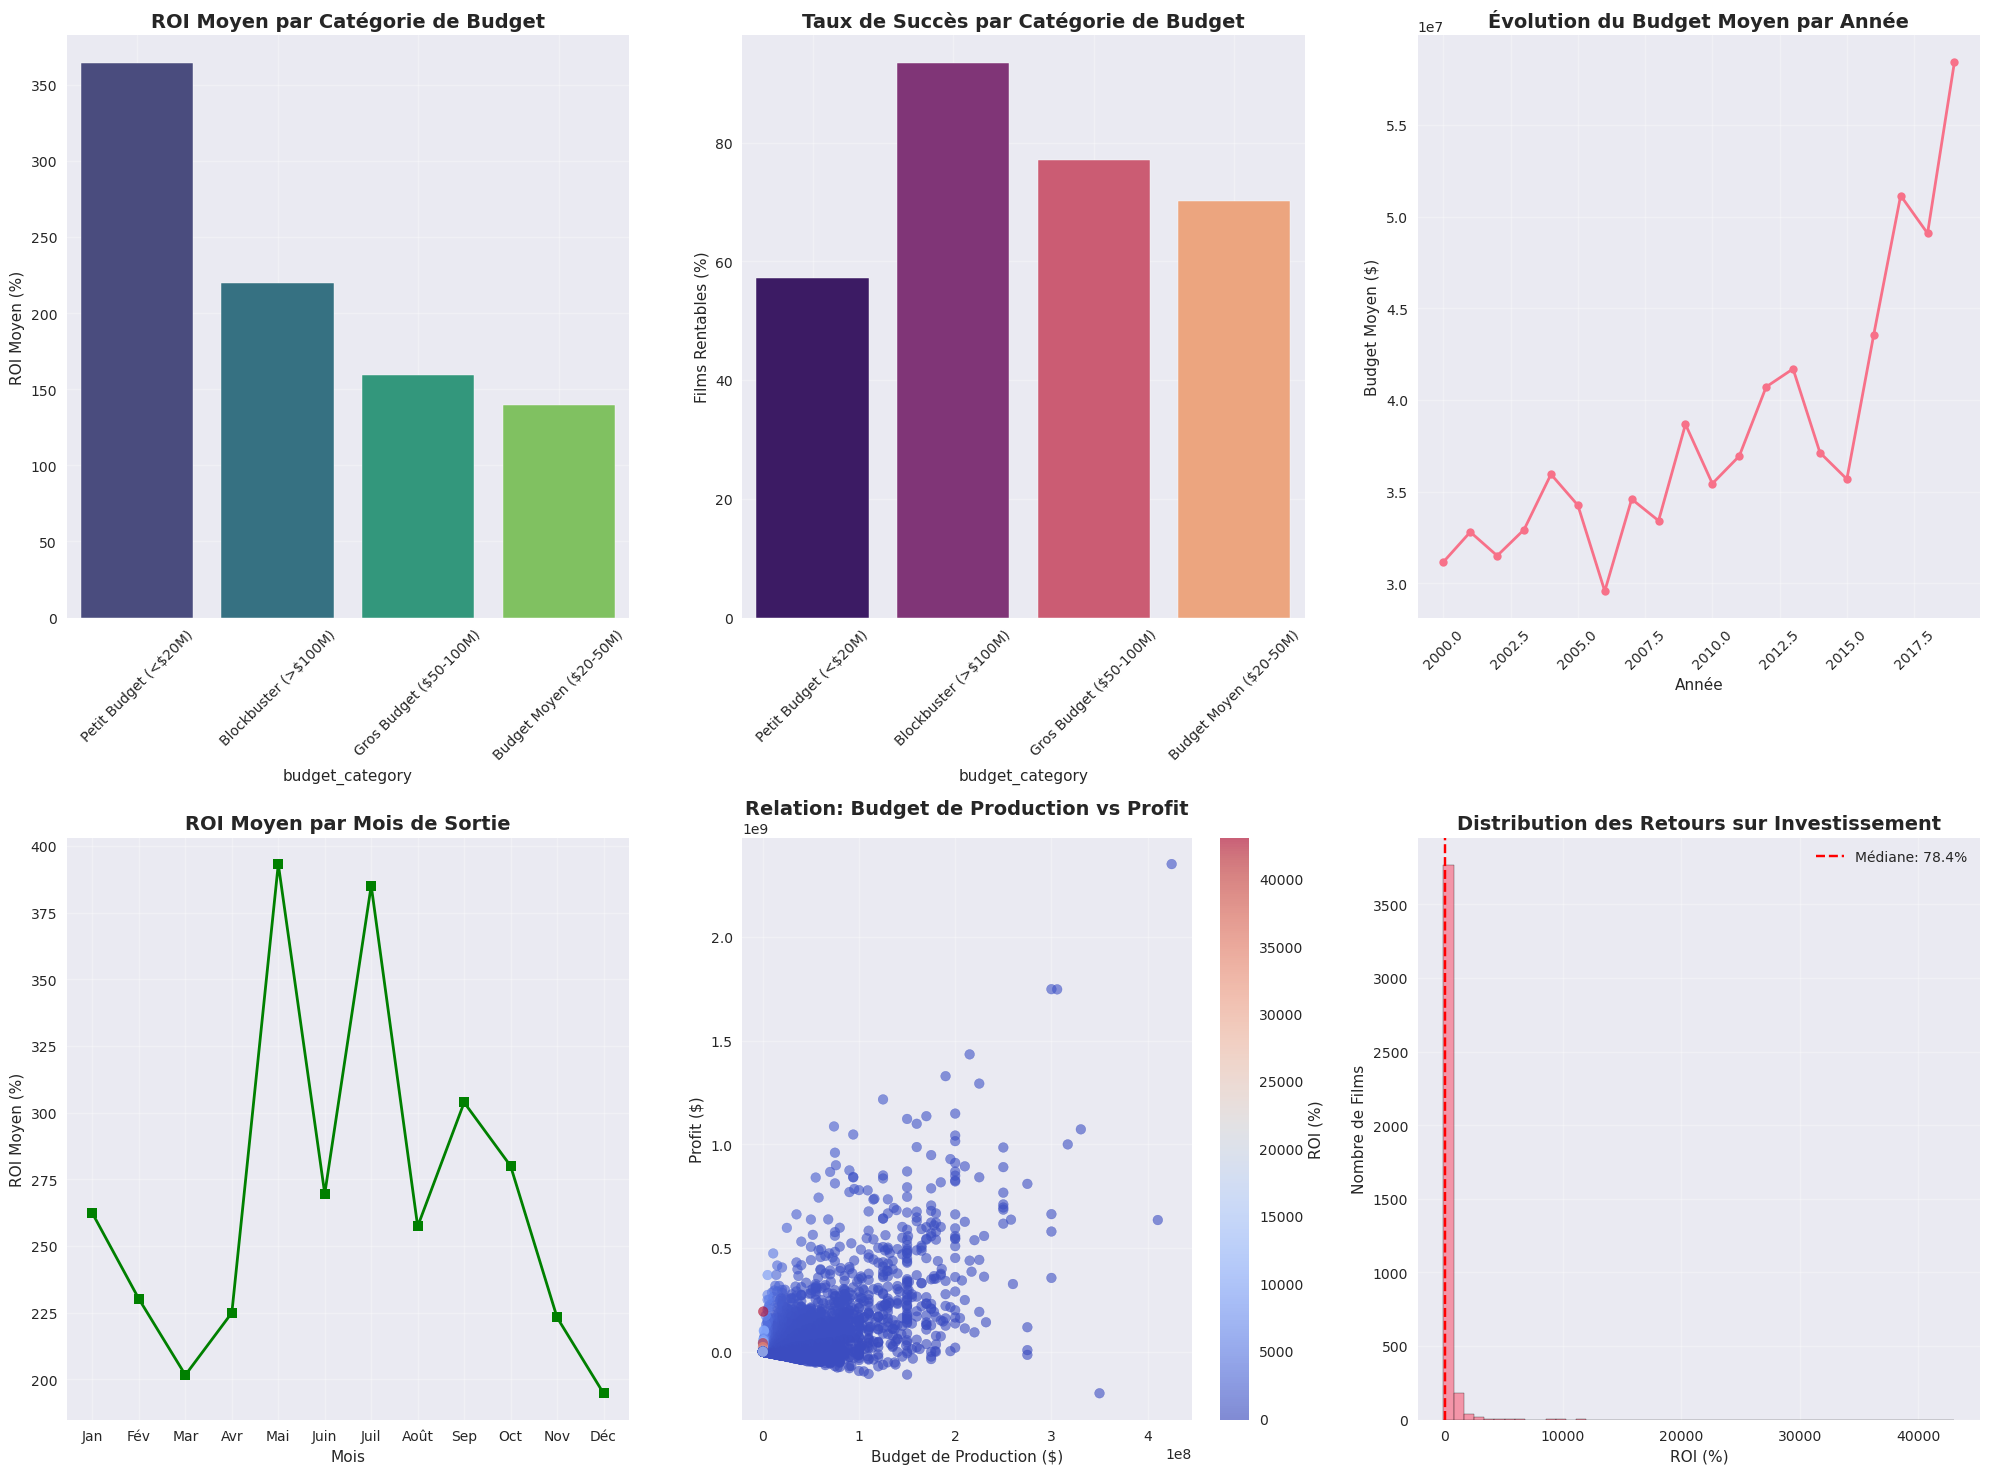

✅ Visualisations créées avec succès


In [31]:
# Création des visualisations
print("\n  ÉTAPE 6: CRÉATION DES VISUALISATIONS")

# Configuration des graphiques
fig = plt.figure(figsize=(20, 15))

# Graphique 1: ROI par catégorie de budget
plt.subplot(2, 3, 1)
sns.barplot(data=budget_performance, x='budget_category', y='avg_roi', palette='viridis')
plt.title('ROI Moyen par Catégorie de Budget', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('ROI Moyen (%)')
plt.grid(True, alpha=0.3)

# Graphique 2: Taux de succès par catégorie
plt.subplot(2, 3, 2)
sns.barplot(data=budget_performance, x='budget_category', y='success_rate', palette='magma')
plt.title('Taux de Succès par Catégorie de Budget', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Films Rentables (%)')
plt.grid(True, alpha=0.3)

# Graphique 3: Évolution du budget moyen
plt.subplot(2, 3, 3)
plt.plot(yearly_trends['release_year'], yearly_trends['avg_budget'], marker='o', linewidth=2, markersize=6)
plt.title('Évolution du Budget Moyen par Année', fontsize=14, fontweight='bold')
plt.xlabel('Année')
plt.ylabel('Budget Moyen ($)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Graphique 4: Performance par mois
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
monthly_performance['month_name'] = month_names
plt.subplot(2, 3, 4)
plt.plot(monthly_performance['month_name'], monthly_performance['avg_roi'], marker='s', linewidth=2, color='green')
plt.title('ROI Moyen par Mois de Sortie', fontsize=14, fontweight='bold')
plt.xlabel('Mois')
plt.ylabel('ROI Moyen (%)')
plt.grid(True, alpha=0.3)

# Graphique 5: Relation Budget vs Profit
plt.subplot(2, 3, 5)
plt.scatter(movies_clean['production_budget'], movies_clean['profit'], alpha=0.6, c=movies_clean['roi'], cmap='coolwarm')
plt.colorbar(label='ROI (%)')
plt.title('Relation: Budget de Production vs Profit', fontsize=14, fontweight='bold')
plt.xlabel('Budget de Production ($)')
plt.ylabel('Profit ($)')
plt.grid(True, alpha=0.3)

# Graphique 6: Distribution des ROI
plt.subplot(2, 3, 6)
plt.hist(movies_clean['roi'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(movies_clean['roi'].median(), color='red', linestyle='--', label=f'Médiane: {movies_clean["roi"].median():.1f}%')
plt.title('Distribution des Retours sur Investissement', fontsize=14, fontweight='bold')
plt.xlabel('ROI (%)')
plt.ylabel('Nombre de Films')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualisations créées avec succès")

# Analyse de haute performance
   Cette cellule identifie les films les plus performants et analyse les caractéristiques communes des films à haut rendement.

In [32]:
# Analyse des films hautement performants
print("\n  ÉTAPE 7: ANALYSE DES FILMS HAUTEMENT PERFORMANTS")

# Identifier les films à haut ROI (top 25%)
roi_threshold = movies_clean['roi'].quantile(0.75)
high_roi_films = movies_clean[movies_clean['roi'] >= roi_threshold]

print(f" Films à haut ROI (top 25% - ROI ≥ {roi_threshold:.1f}%): {len(high_roi_films)} films")

# Caractéristiques des films à haut ROI
high_roi_stats = high_roi_films.agg({
    'production_budget': ['median', 'min', 'max'],
    'profit': 'median',
    'roi': 'median'
}).round(2)

print("\n CARACTÉRISTIQUES DES FILMS À HAUT ROI:")
print(f"• Budget médian: ${high_roi_stats.iloc[0,0]:,.0f}")
print(f"• Profit médian: ${high_roi_stats.iloc[1,0]:,.0f}")
print(f"• ROI médian: {high_roi_stats.iloc[2,0]:.1f}%")

# Analyser la répartition par catégorie de budget pour les films à haut ROI
high_roi_by_budget = high_roi_films['budget_category'].value_counts()
print(f"\n  RÉPARTITION DES FILMS À HAUT ROI PAR CATÉGORIE:")
for category, count in high_roi_by_budget.items():
    percentage = (count / len(high_roi_films)) * 100
    print(f"• {category}: {count} films ({percentage:.1f}%)")

# Analyser les mois les plus performants pour les films à haut ROI
high_roi_by_month = high_roi_films['release_month'].value_counts().sort_index()
print(f"\n📅 RÉPARTITION MOIS PAR MOIS DES FILMS À HAUT ROI:")
for month, count in high_roi_by_month.items():
    print(f"• {month_names[month-1]}: {count} films")


  ÉTAPE 7: ANALYSE DES FILMS HAUTEMENT PERFORMANTS
 Films à haut ROI (top 25% - ROI ≥ 262.2%): 1009 films

 CARACTÉRISTIQUES DES FILMS À HAUT ROI:
• Budget médian: $17,500,000
• Profit médian: $1,100
• ROI médian: 425000000.0%

  RÉPARTITION DES FILMS À HAUT ROI PAR CATÉGORIE:
• Petit Budget (<$20M): 563 films (55.8%)
• Budget Moyen ($20-50M): 208 films (20.6%)
• Blockbuster (>$100M): 127 films (12.6%)
• Gros Budget ($50-100M): 111 films (11.0%)

📅 RÉPARTITION MOIS PAR MOIS DES FILMS À HAUT ROI:
• Jan: 73 films
• Fév: 81 films
• Mar: 81 films
• Avr: 69 films
• Mai: 78 films
• Juin: 86 films
• Juil: 95 films
• Août: 82 films
• Sep: 71 films
• Oct: 89 films
• Nov: 95 films
• Déc: 109 films


#          RECOMMANDATIONS STRATÉGIQUES
============================================================
  
####      STRATÉGIE DE PRODUCTION OPTIMALE:
• Catégorie de budget recommandée: Petit Budget (<$20M)

• Budget moyen cible: $8,558,406

• ROI moyen attendu: 364.3%


• Taux de succès historique: 57.1%

****STRATÉGIE DE SORTIE:****

• Meilleur mois de sortie: Mai

• ROI moyen ce mois: 393.2%


****⚠️  GESTION DES RISQUES:****

• Taux de succès petits budgets: 57.1%

• Taux de succès blockbusters: 93.4%

• Différence de risque: 36.2 points


##### PLAN D'ACTION RECOMMANDÉ:

   **1. PHASE 1 (Année 1-2):** Focus sur les budgets $20-50M avec sorties ciblées
      
   **2. PHASE 2 (Année 3-4):** Expansion vers budgets $50-100M avec diversification

   **3. PHASE 3 (Année 5+):** Introduction progressive de productions blockbuster
   
   **4. MARKETING:** Budget de marketing = 30-50% du budget de production
   
   **5. DIVERSIFICATION:** 70% productions sûres + 30% productions innovantes


### 📋 SYNTHÈSE FINALE POUR LE STUDIO:

****STRATÉGIE PRINCIPALE****: Petit Budget (<$20M)
    
****💰 BUDGET CIBLE:**** $8,558,406

****📈 ROI ATTENDU****: 364.3%

****📅 MEILLEURE PÉRIODE:**** Mai

 ****TAUX DE SUCCÈS:**** 57.1%

####    PROCHAINES ÉTAPES:

   1. Développer 2-3 scénarios dans la catégorie budget recommandée
     
   2. Planifier les sorties sur les mois identifiés comme optimaux
    
   3. Établir des partenariats de distribution internationale
    
   4. Mettre en place un système de suivi des performances
    
   5. Réévaluer la stratégie après les 2 premières productions

 
                        ======================================================================================

                            Le succès dans le cinéma ne vient pas de gros budgets, mais de bons calculs.
   -                                             Votre équipe d'analyse data
                             =========================================================================
